In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, levene
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")

# Load the Data

In [ ]:
url = 'https://raw.githubusercontent.com/pariscwang/early-childhood-development/main/data.csv'
df = pd.read_csv(url)
df.head(3)

,fallreadingscore,fallmathscore,fallgeneralknowledgescore,springreadingscore,springmathscore,springgeneralknowledgescore,totalhouseholdincome,incomeinthousands,incomegroup
0,36.58,39.54,33.822,49.37,50.10,40.533,140000.0,140.0,3
1,50.82,44.44,38.147,83.50,58.93,37.409,120000.0,120.0,3
2,40.68,28.57,28.108,40.41,32.81,29.312,90000.0,90.0,3


# About the Data

In [ ]:
# Use general knolwedge as a baseline to compare how students reading score and math score change over time, by income group
# two-way ANOVA, interaction plot

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fallreadingscore             11933 non-null  float64
 1   fallmathscore                11933 non-null  float64
 2   fallgeneralknowledgescore    11933 non-null  float64
 3   springreadingscore           11933 non-null  float64
 4   springmathscore              11933 non-null  float64
 5   springgeneralknowledgescore  11933 non-null  float64
 6   totalhouseholdincome         11933 non-null  float64
 7   incomeinthousands            11933 non-null  float64
 8   incomegroup                  11933 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 839.2 KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fallreadingscore,11933.0,35.954215,10.473130,21.010,29.340,34.060,39.890,138.510
fallmathscore,11933.0,27.128244,9.120505,10.510,20.680,25.680,31.590,115.650
fallgeneralknowledgescore,11933.0,23.073694,7.396978,6.985,17.385,22.954,28.305,47.691
springreadingscore,11933.0,47.511178,14.327111,22.350,38.950,45.320,51.770,156.850
springmathscore,11933.0,37.799461,12.027753,11.900,29.270,36.410,44.220,113.800
springgeneralknowledgescore,11933.0,28.235584,7.577457,7.858,22.802,28.583,33.782,48.345
totalhouseholdincome,11933.0,54317.199930,36639.061147,1.000,27000.000,47000.000,72000.000,150000.000
incomeinthousands,11933.0,54.317200,36.639061,0.001,27.000,47.000,72.000,150.000
incomegroup,11933.0,1.895165,0.822692,1.000,1.000,2.000,3.000,3.000


A quick overview of the data shows that both reading and math scores in fall and spring both have potential outliers.
- There seems to be a significant difference in the mean reading scores from fall and spring, which is not observed for math scores or general knowledge scores.
- Household income appears to be very dispersely distributed, with a large standard deviation, a minimum of no household income and a maximum of $$150K, around 3 standard deviations higher from the mean household incoome of $54.3K. This is a sing to pay attention to income disparity in later analysis.
- Based on household income, families are categorized into 3 income groups -> pivot table of three income groups with min income, max income, and distribution of scores.

In [ ]:
df = df.drop('totalhouseholdincome', axis = 1)

In [ ]:
df

,fallreadingscore,fallmathscore,fallgeneralknowledgescore,springreadingscore,springmathscore,springgeneralknowledgescore,incomeinthousands,incomegroup
0,36.58,39.54,33.822,49.37,50.10,40.533,140.0,3
1,50.82,44.44,38.147,83.50,58.93,37.409,120.0,3
2,40.68,28.57,28.108,40.41,32.81,29.312,90.0,3
3,32.57,23.57,15.404,34.14,35.25,27.382,50.0,2
4,31.98,19.65,18.727,32.84,23.60,26.977,55.0,2
...,...,...,...,...,...,...,...,...
11928,32.51,25.68,11.694,45.63,24.27,20.189,39.0,1
11929,31.96,25.73,21.461,47.84,40.35,32.357,26.0,1
11930,40.44,30.50,16.836,49.93,41.00,19.803,45.0,2
11931,35.51,28.96,28.864,51.60,50.27,35.991,28.0,1


## Feature Engineering

In [ ]:
# Rename columns for clarity
df = df.rename(columns = {'fallreadingscore':'fall_reading',
                          'springreadingscore':'spring_reading',
                          'fallmathscore':'fall_math',
                          'springmathscore':'spring_math',
                          'fallgeneralknowledgescore':'fall_general',
                          'springgeneralknowledgescore':'spring_general',
                          'incomeinthousands':'household_income'})

In [ ]:
# Rearrange column order for boxplot
df = df[['fall_reading','spring_reading','fall_math','spring_math','fall_general','spring_general','household_income','incomegroup']]

## Distribution

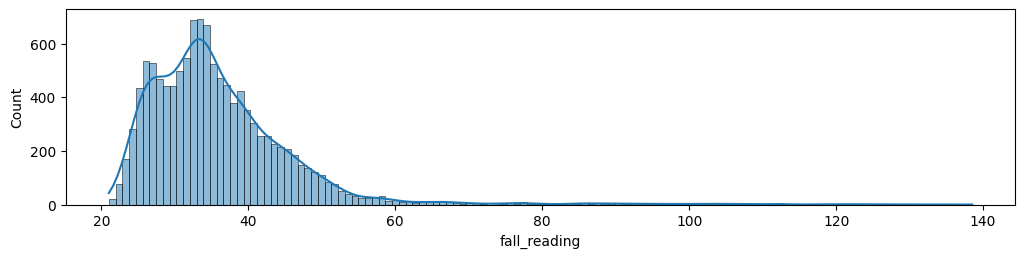

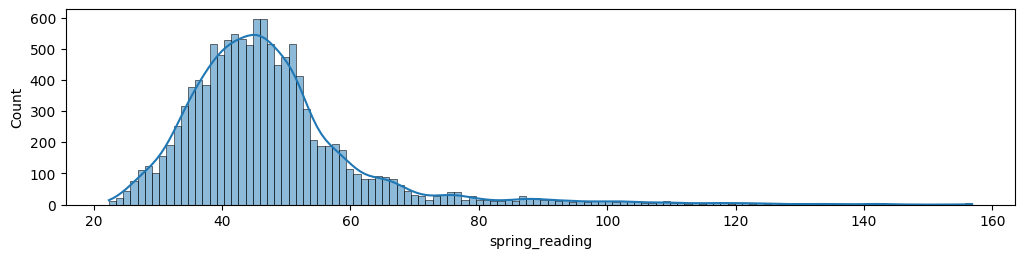

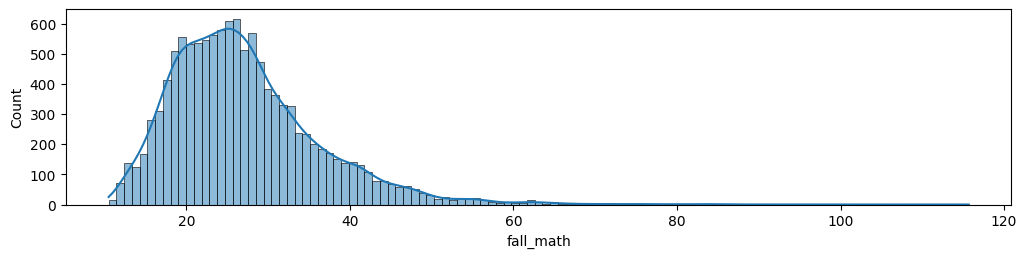

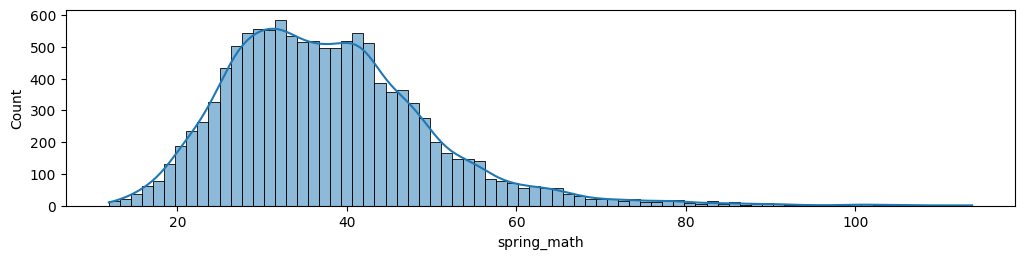

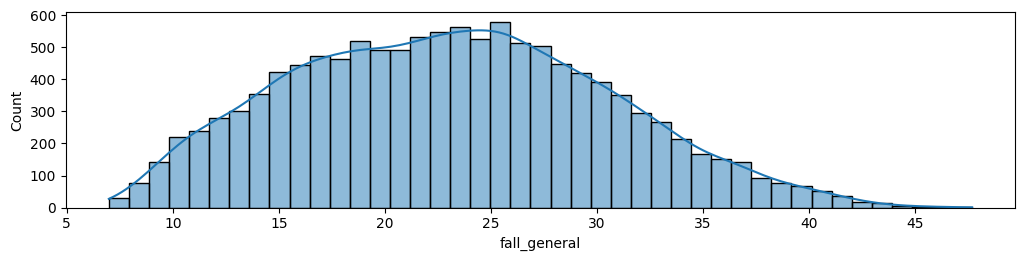

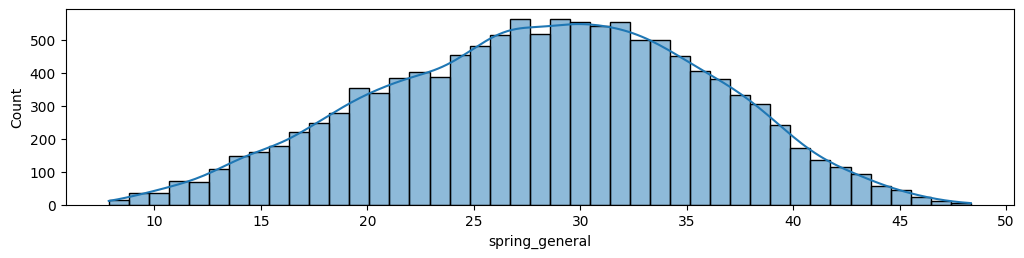

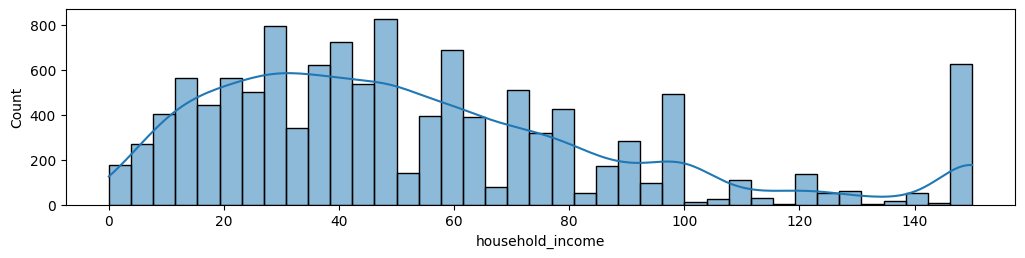

In [ ]:
# Distribution by feature

index=0

for feature in df.select_dtypes('number').columns[:7]:
    index+=1
    plt.figure(figsize=(20,20))
    plt.subplot((len(df.columns)),2,index)
    # Extended whis to 3 for less aggressive outlier detection
    sns.histplot(df[feature], kde=True)

    plt.tight_layout()

    plt.show()

## Distribution of Income by Income Group

Text(0.5, 1.0, 'Distribution of Income by Income Group')

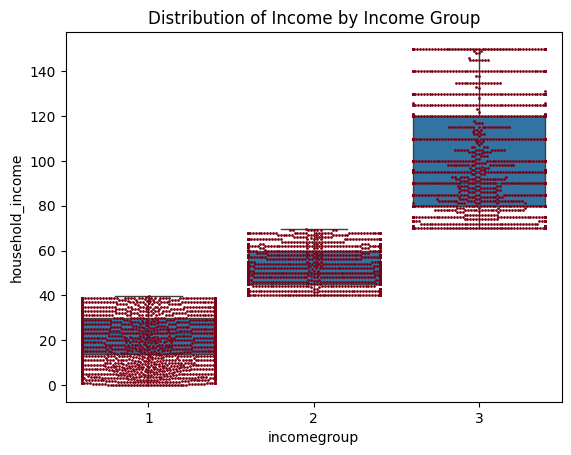

In [ ]:
ax = sns.boxplot( x = 'incomegroup', y = 'household_income', data = df)

ax = sns.swarmplot(x="incomegroup", y="household_income", data=df, color='#7d0013',size=2)

# Omitting swarmplot for run time purposes
# ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

plt.title("Distribution of Income by Income Group")

In [ ]:
print('\nStatistics Summary of Income by Income Group\n')
df.groupby(['incomegroup'])['household_income'].agg(['mean','median','min','max','count']).round(2)


Statistics Summary of Income by Income Group



,mean,median,min,max,count
incomegroup,,,,,
1,22.02,23.0,0.0,39.8,4729
2,51.74,50.0,40.0,69.7,3726
3,100.99,90.0,70.0,150.0,3478


An overview of income distribution by income group shows that income group 1 includes families with household income from zero to 40k, income group 2 includes families with household income grom 40k to 70k, income group 3 includes families with household income from 70k to over 150k.

However a closer look at each distribution shows that although income distribution is roughly normal for the lowest income group, both group 2 and 3 have right skewed distributions, with a median closer to their lower bounds

From the boxplot, it appears that there is a consistent upwards trend in reading, math, and general knowledge scores from fall to spring across all three income groups. The next step in the analysis would be to use statistical tests (t-test/ANCOVA) with income groups as the categorical explanatory variable, and reading, math and general knowledge scores as quantitative variables or “control variables”

Note that a reasonable (initial) statistical model for these data is that for any combination of season and income group the score outcome is normally distributed with equal variance. However, there seems to be a good amount of outliers especially for reading and math scores.

## Distribution of **Changes** in Reading, Math & GK Scores across Income Groups

In [ ]:
# Create a new dataframe for score difference
df_diff = pd.DataFrame()

df_diff['reading_diff'] = df['spring_reading'] - df['fall_reading']
df_diff['math_diff'] = df['spring_math'] - df['fall_math']
df_diff['gk_diff'] = df['spring_general'] - df['fall_general']
df_diff['incomegroup'] = df['incomegroup']

Text(0.5, 1.0, 'Distribution of Reading Score Difference from Fall - Spring by Income Group')

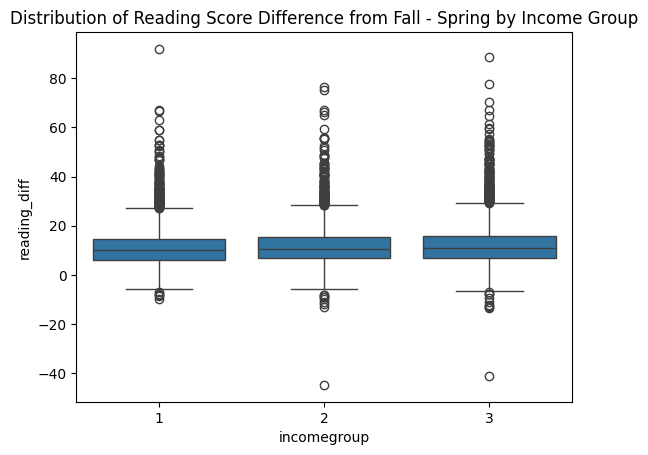

In [ ]:
ax = sns.boxplot(x = 'incomegroup', y = 'reading_diff', data = df_diff )
plt.title("Distribution of Reading Score Difference from Fall - Spring by Income Group")

The medians are above zero for all income groups, indicating general improvement. The distribution looks similar at a glance, with outlier patterns showing slight differences across income groups.

Text(0.5, 1.0, 'Distribution of Math Score Difference from Fall - Spring by Income Group')

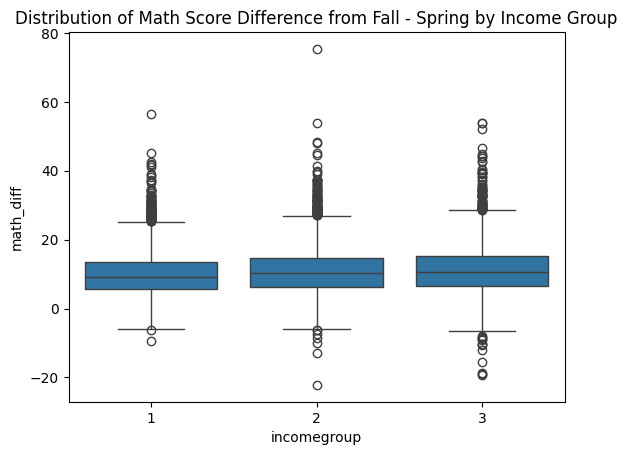

In [ ]:
ax = sns.boxplot(x = 'incomegroup', y = 'math_diff', data = df_diff )
plt.title("Distribution of Math Score Difference from Fall - Spring by Income Group")

There is less variability in the math score differences compared to reading, however, outliers are present across 3 income groups.

Text(0.5, 1.0, 'Distribution of General Knowledge Score Difference from Fall - Spring by Income Group')

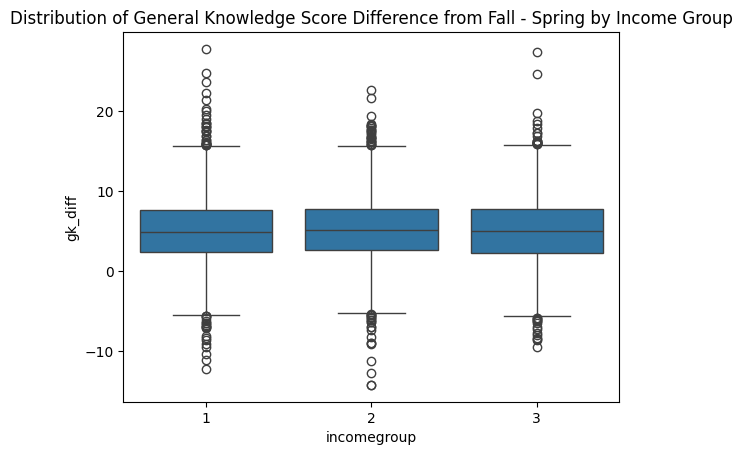

In [ ]:
ax = sns.boxplot(x = 'incomegroup', y = 'gk_diff', data = df_diff )
plt.title("Distribution of General Knowledge Score Difference from Fall - Spring by Income Group")

From initial exploratory visualization, it looks like The spread of score differences (interquartile range) is fairly consistent across income groups, with general knowledge score difference having more prominent outliers in income group 1 and 2.

# Statistical Test

In [ ]:
import scipy.stats as stats
%pip install bioinfokit
from bioinfokit.analys import stat

*Research Question*:
Does the income group have a significant effect on children's scores after controlling for their baseline scores?

## One-way ANCOVA 1

In [ ]:
model = ols('spring_reading ~ incomegroup + fall_reading + incomegroup * fall_reading', data=df).fit()
ancova_results = sm.stats.anova_lm(model, typ=2)
print(ancova_results.round(3))

                               sum_sq       df          F  PR(>F)
incomegroup                   469.981      1.0      7.432   0.006
fall_reading              1547012.917      1.0  24463.318   0.000
incomegroup:fall_reading      301.795      1.0      4.772   0.029
Residual                   754366.896  11929.0        NaN     NaN


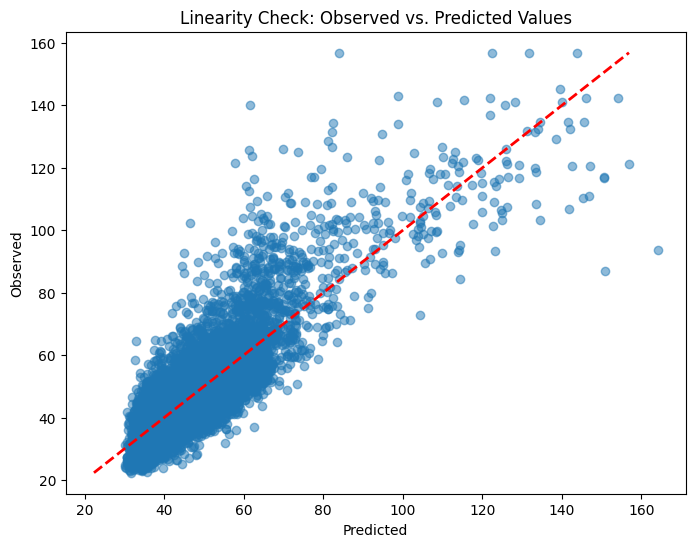

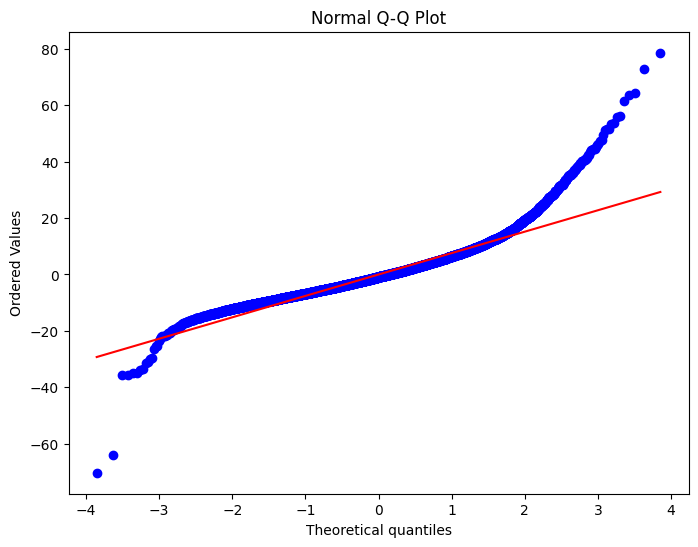

Homogeneity of variances (Levene’s test): Stat=39.553, p-value=0.000


In [ ]:
# Checking Linearity
# Plotting observed vs. predicted values
plt.figure(figsize=(8, 6))
predicted = model.fittedvalues
observed = df['spring_reading']
plt.scatter(predicted, observed, alpha=0.5)
plt.plot([observed.min(), observed.max()], [observed.min(), observed.max()], '--r', linewidth=2)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.title('Linearity Check: Observed vs. Predicted Values')
plt.show()

# Checking Normality of Residuals with Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(model.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.show()

# Checking Homogeneity of Variances with Levene's Test
grouped_data = df.groupby('incomegroup')['spring_reading'].apply(list)
s, p_value = levene(*grouped_data)
print(f'Homogeneity of variances (Levene’s test): Stat={s:.3f}, p-value={p_value:.3f}')

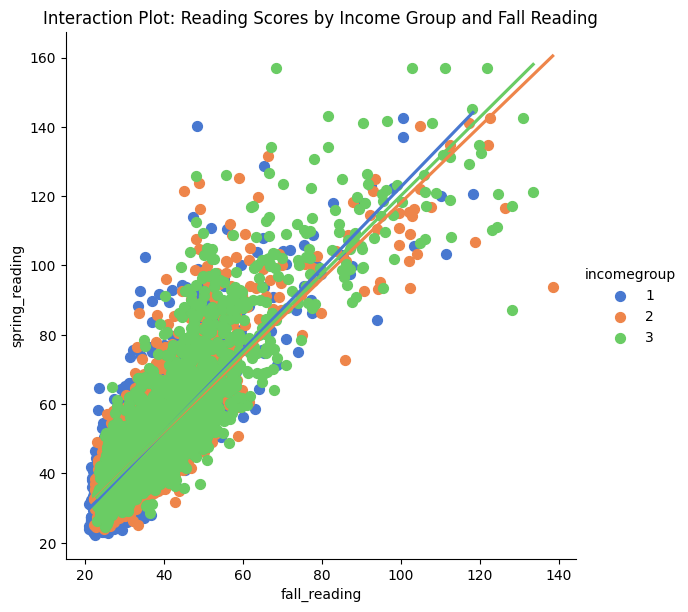

Normality of residuals (Shapiro-Wilk test): Statistics=0.912, p=0.000


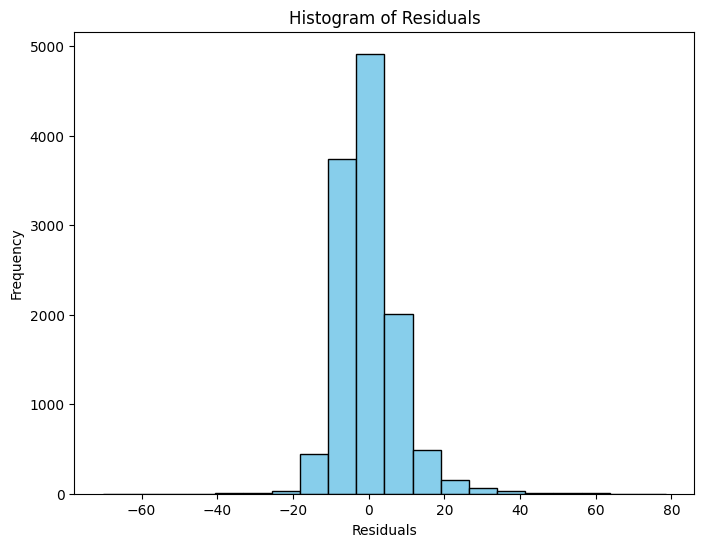

In [ ]:
# Interaction Plots
sns.lmplot(x='fall_reading', y='spring_reading', hue='incomegroup', data=df,
           ci=None, palette="muted", height=6, scatter_kws={"s": 50, "alpha": 1})
plt.title('Interaction Plot: Reading Scores by Income Group and Fall Reading')
plt.show()

# Checking Normality of Residuals for Interaction Model with Shapiro-Wilk Test
s, p = shapiro(model.resid)
print(f'Normality of residuals (Shapiro-Wilk test): Statistics={s:.3f}, p={p:.3f}')

# Residual Histogram
residuals = model.resid
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


## One-way ANCOVA 2

In [ ]:
model = ols('spring_math ~ incomegroup + fall_math + incomegroup * fall_math', data=df).fit()
ancova_results = sm.stats.anova_lm(model, typ=2)
print(ancova_results.round(3))

                            sum_sq       df          F  PR(>F)
incomegroup               1600.557      1.0     34.719     0.0
fall_math              1026632.731      1.0  22269.515     0.0
incomegroup:fall_math     1680.414      1.0     36.451     0.0
Residual                549931.229  11929.0        NaN     NaN


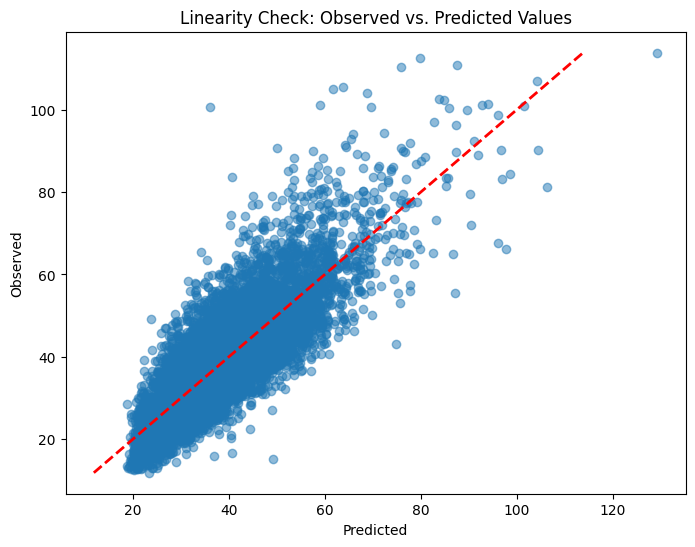

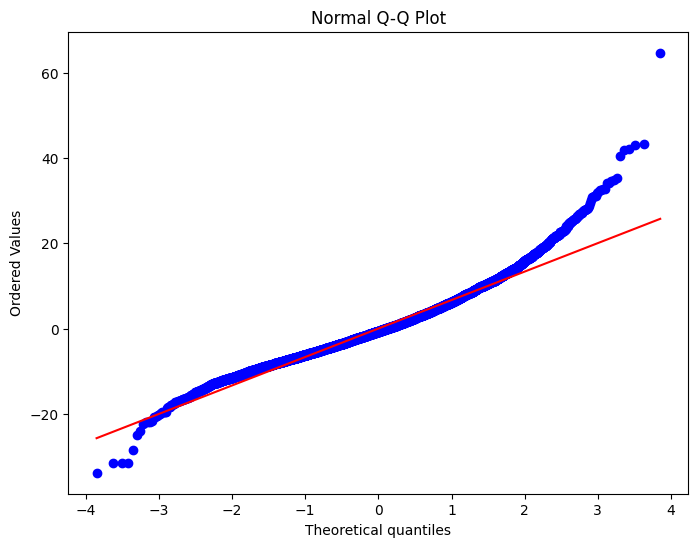

Homogeneity of variances (Levene’s test): Stat=18.900, p-value=0.000


In [ ]:
# Checking Linearity
# Plotting observed vs. predicted values
plt.figure(figsize=(8, 6))
predicted = model.fittedvalues
observed = df['spring_math']
plt.scatter(predicted, observed, alpha=0.5)
plt.plot([observed.min(), observed.max()], [observed.min(), observed.max()], '--r', linewidth=2)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.title('Linearity Check: Observed vs. Predicted Values')
plt.show()

# Checking Normality of Residuals with Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(model.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.show()

# Checking Homogeneity of Variances with Levene's Test
import scipy.stats as stats
grouped_data = df.groupby('incomegroup')['spring_math'].apply(list)
s, p_value = levene(*grouped_data)
print(f'Homogeneity of variances (Levene’s test): Stat={s:.3f}, p-value={p_value:.3f}')

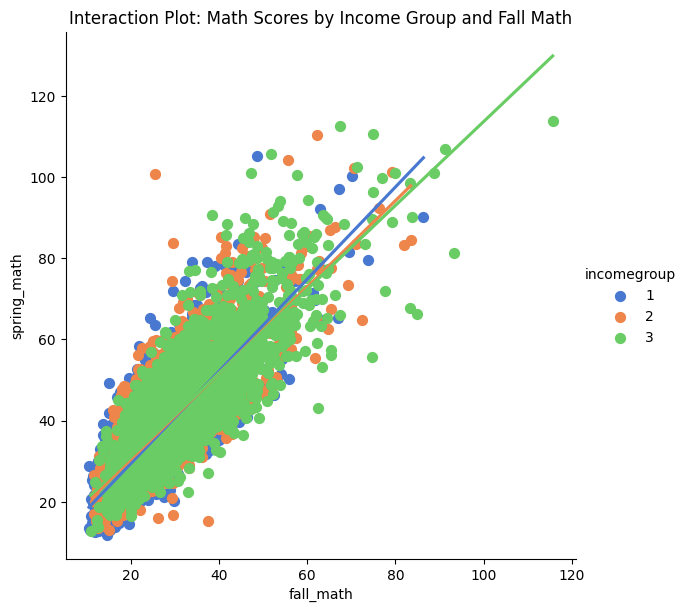

Normality of residuals (Shapiro-Wilk test): Statistics=0.965, p=0.000


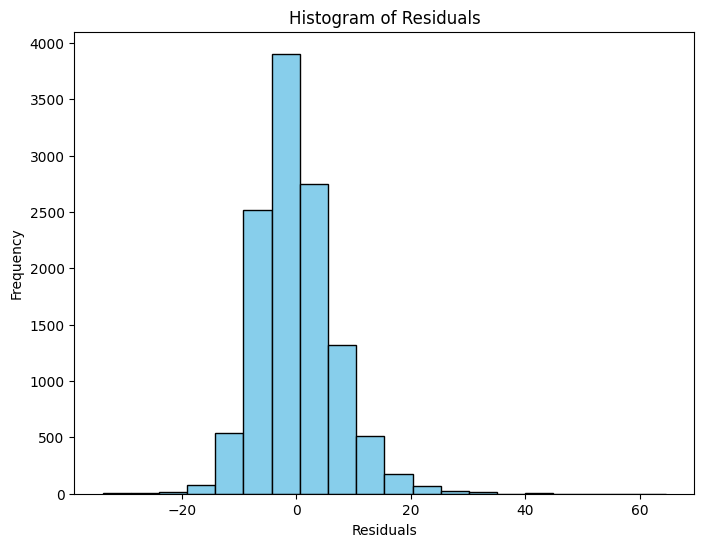

In [ ]:
# Interaction Plots
sns.lmplot(x='fall_math', y='spring_math', hue='incomegroup', data=df,
           ci=None, palette="muted", height=6, scatter_kws={"s": 50, "alpha": 1})
plt.title('Interaction Plot: Math Scores by Income Group and Fall Math')
plt.show()

# Checking Normality of Residuals for Interaction Model with Shapiro-Wilk Test
s, p = shapiro(model.resid)
print(f'Normality of residuals (Shapiro-Wilk test): Statistics={s:.3f}, p={p:.3f}')

# Residual Histogram
residuals = model.resid
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


## One-way ANCOVA 3

In [ ]:
model = ols('spring_general ~ incomegroup + fall_general + incomegroup * fall_general', data=df).fit()
ancova_results = sm.stats.anova_lm(model, typ=2)
print(ancova_results.round(3))

                              sum_sq       df          F  PR(>F)
incomegroup                 1614.073      1.0    104.936     0.0
fall_general              413465.233      1.0  26880.795     0.0
incomegroup:fall_general     797.862      1.0     51.872     0.0
Residual                  183485.150  11929.0        NaN     NaN


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         spring_general   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                 1.087e+04
Date:                Fri, 29 Mar 2024   Prob (F-statistic):               0.00
Time:                        10:11:21   Log-Likelihood:                -33238.
No. Observations:               11933   AIC:                         6.648e+04
Df Residuals:                   11929   BIC:                         6.651e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.7265      0.289     19.823      0.000       5.160       6.293
incomegroup                  1.5052      0.150     10.046      0.000       1.211       1.799
fall_general                 0.9395      0.013     73.109      0.000       0.914       0.965
incomegroup:fall_general    -0.0440      0.006     -7.202      0.000      -0.056      -0.032
==============================================================================
Omnibus:                       78.490   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.098
Skew:                           0.081   Prob(JB):                     3.36e-24
Kurtosis:                       3.437   Cond. No.                         524.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

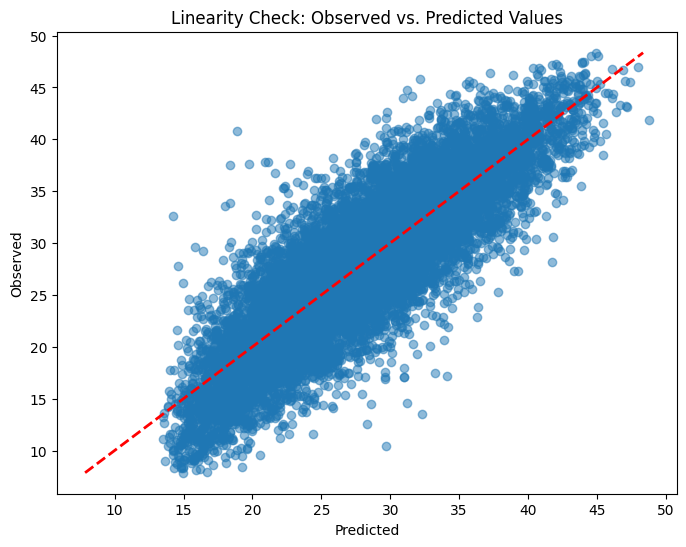

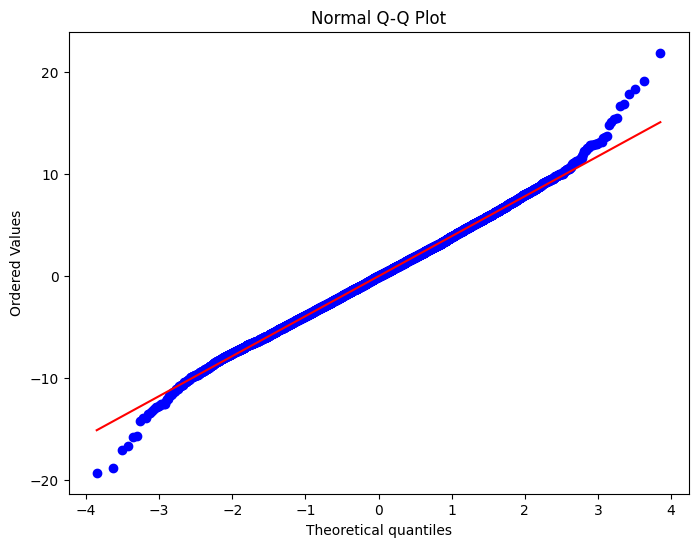

Homogeneity of variances (Levene’s test): Stat=18.900, p-value=0.000


In [ ]:
# Checking Linearity
# Plotting observed vs. predicted values
plt.figure(figsize=(8, 6))
predicted = model.fittedvalues
observed = df['spring_general']
plt.scatter(predicted, observed, alpha=0.5)
plt.plot([observed.min(), observed.max()], [observed.min(), observed.max()], '--r', linewidth=2)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.title('Linearity Check: Observed vs. Predicted Values')
plt.show()

# Checking Normality of Residuals with Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(model.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.show()

# Checking Homogeneity of Variances with Levene's Test
import scipy.stats as stats
grouped_data = df.groupby('incomegroup')['spring_math'].apply(list)
s, p_value = levene(*grouped_data)
print(f'Homogeneity of variances (Levene’s test): Stat={s:.3f}, p-value={p_value:.3f}')

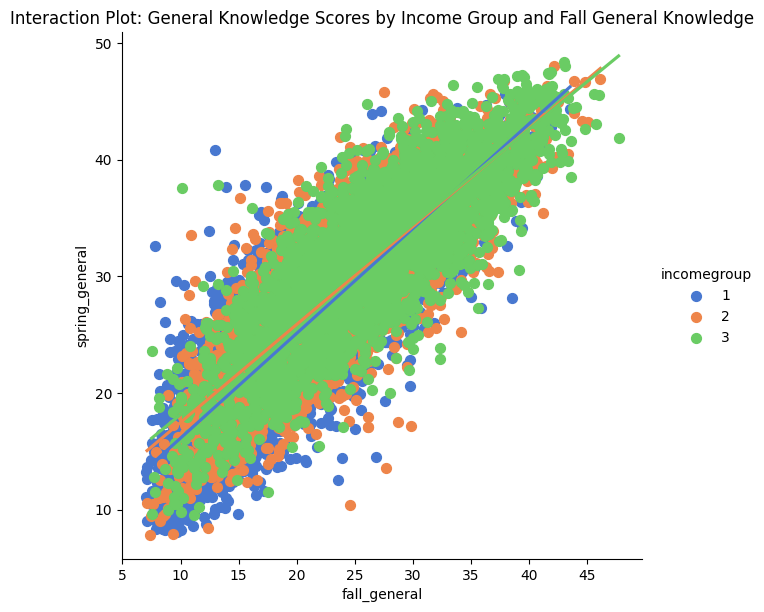

Normality of residuals (Shapiro-Wilk test): Statistics=0.998, p=0.000


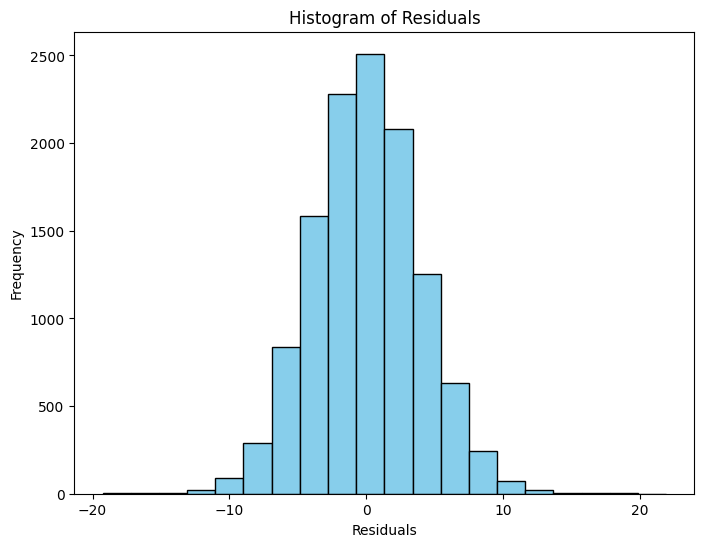

In [ ]:
# Interaction Plots
sns.lmplot(x='fall_general', y='spring_general', hue='incomegroup', data=df,
           ci=None, palette="muted", height=6, scatter_kws={"s": 50, "alpha": 1})
plt.title('Interaction Plot: General Knowledge Scores by Income Group and Fall General Knowledge')
plt.show()

# Checking Normality of Residuals for Interaction Model with Shapiro-Wilk Test
s, p = shapiro(model.resid)
print(f'Normality of residuals (Shapiro-Wilk test): Statistics={s:.3f}, p={p:.3f}')

# Residual Histogram
residuals = model.resid
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


**Additional Research questions**

1. Is there a significant change in score performance over time (within subject) and across income groups (between subject)?
2. If so, is the change over time consistent across income groups? (interaction/mixed design)

For this analysis, a two-way ANOVA is conducted to compare the mean scores of three or more income groups and explore whether there are any statistically significant differences between the means of the different income groups.


The primary focus of this analysis is to study reading/math/general knowledge scores across income groups and the change of such over time (from fall to spring).

This is a with-in subject desing, since the same subjects (kindergarten children) are measured twice under different conditions (fall and spring). In within-subjects designs, each participant acts as their own control, which helps to control for individual differences that could affect the outcome (score performance). Since each child's scores in reading, math, and general knowledge are collected in both fall and spring, we can effectively remove subject-to-subject variation such as home and classroom environment, from our study of the relative effects of different household income levels.



## Two-way ANOVA

In [ ]:
def two_way_anova(df, score_type):
    # Reshape the DataFrame to long format
    df_melt = pd.melt(df, id_vars=['incomegroup'],
                      value_vars=[f'fall_{score_type}', f'spring_{score_type}'],
                      var_name='time', value_name=f'{score_type}_score')

    # Convert categorical variables to 'category' type
    df_melt['time'] = df_melt['time'].astype('category')
    df_melt['incomegroup'] = df_melt['incomegroup'].astype('category')

    # Create boxplots
    sns.boxplot(x='incomegroup', y=f'{score_type}_score', hue='time', data=df_melt, palette='Set3_r')
    plt.title(f"Distribution of Fall and Spring {score_type.capitalize()} Scores by Income Group\n")
    plt.show()
    print('-'*80, '\n')


    # Perform two-way ANOVA
    model = ols(f'{score_type}_score ~ C(incomegroup) + C(time) + C(incomegroup):C(time)', data=df_melt).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table.round(3))
    print('-'*80, '\n')

    # Interaction plot
    interaction_plot(x=df_melt['incomegroup'], trace=df_melt['time'], response=df_melt[f'{score_type}_score'], colors=['#4c061d','#d17a22'])
    plt.title(f'Interaction Plot of {score_type.capitalize()} Scores by Income Group and Time\n')
    plt.xlabel('Income Group')
    plt.ylabel(f'{score_type.capitalize()} Score')
    plt.show()
    print('-'*80, '\n')

    res = stat()

    # Tukey's HSD for income groups
    res.tukey_hsd(df=df_melt, res_var=f'{score_type}_score', xfac_var='incomegroup',
                  anova_model=f'{score_type}_score ~ C(incomegroup) + C(time) + C(incomegroup):C(time)')
    print('Tukeys HSD for Income Groups\n')
    print(res.tukey_summary.round(3))
    print('-'*80, '\n')

    # Tukey's HSD for time
    res.tukey_hsd(df=df_melt,res_var=f'{score_type}_score',xfac_var='time',
                  anova_model=f'{score_type}_score ~ C(incomegroup) + C(time) + C(incomegroup):C(time)')
    print('\nTukeys HSD for Time\n')
    print(res.tukey_summary.round(3))
    print('-'*80, '\n')

    # Effect Size
    SS_effect_income = anova_table.loc['C(incomegroup)', 'sum_sq']
    SS_effect_time = anova_table.loc['C(time)', 'sum_sq']
    SS_effect_interaction = anova_table.loc['C(incomegroup):C(time)', 'sum_sq']
    SS_error = anova_table.loc['Residual', 'sum_sq']

    # Calculate partial eta squared for each effect
    eta_squared_income = SS_effect_income / (SS_effect_income + SS_error)
    eta_squared_time = SS_effect_time / (SS_effect_time + SS_error)
    eta_squared_interaction = SS_effect_interaction / (SS_effect_interaction + SS_error)

    print(f"Effect Size for Income Group: {eta_squared_income.round(3)}")
    print(f"Effect Size for Time: {eta_squared_time.round(3)}")
    print(f"Effect Size for Interaction: {eta_squared_interaction.round(3)}")
    print('-'*80, '\n')

    # Check for normality of the residuals
    model = ols(f'{score_type}_score ~ C(incomegroup) * C(time)', data=df_melt).fit()
    residuals = model.resid

    # Residual Histogram
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')
    plt.show()

    stats, p_value = shapiro(residuals)
    print(f'Normality of residuals (Shapiro-Wilk): Stat={stats:.3f}, p-value={p_value:.3f}')
    print('-'*80, '\n')

    # Check for homogeneity of variances
    groups = df_melt.groupby(['incomegroup', 'time'])[f'{score_type}_score'].apply(list)
    stats, p_value = levene(*groups)
    print(f'Homogeneity of variances (Levene’s test): Stat={stats:.3f}, p-value={p_value:.3f}')


###Reading


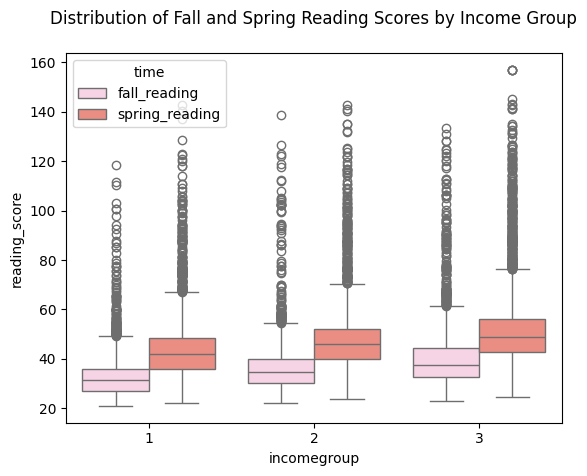

-------------------------------------------------------------------------------- 

                             sum_sq       df         F  PR(>F)
C(incomegroup)           247427.306      2.0   841.338   0.000
C(time)                  796905.995      1.0  5419.510   0.000
C(incomegroup):C(time)     2118.698      2.0     7.204   0.001
Residual                3508467.935  23860.0       NaN     NaN
-------------------------------------------------------------------------------- 



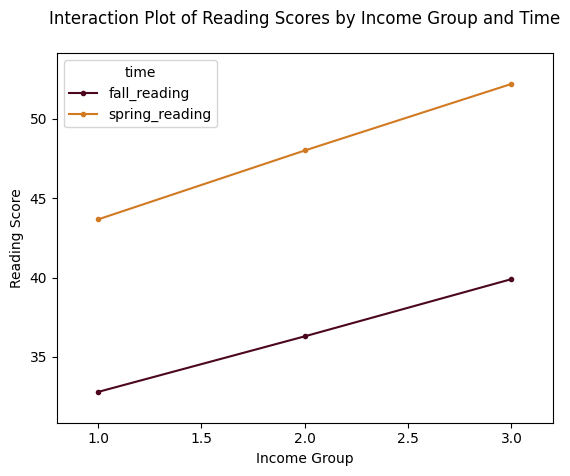

-------------------------------------------------------------------------------- 

Tukeys HSD for Income Groups

   group1  group2   Diff  Lower  Upper  q-value  p-value
0       3       2  3.902  3.428  4.376   27.294    0.001
1       3       1  7.827  7.378  8.276   57.789    0.001
2       2       1  3.925  3.485  4.365   29.553    0.001
-------------------------------------------------------------------------------- 


Tukeys HSD for Time

         group1          group2    Diff   Lower   Upper  q-value  p-value
0  fall_reading  spring_reading  11.557  11.249  11.865  104.111    0.001
-------------------------------------------------------------------------------- 

Effect Size for Income Group: 0.066
Effect Size for Time: 0.185
Effect Size for Interaction: 0.001
-------------------------------------------------------------------------------- 



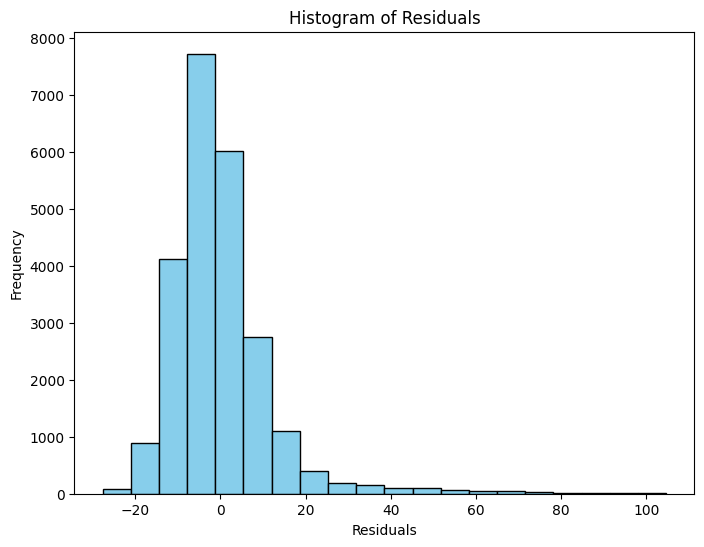

Normality of residuals (Shapiro-Wilk): Stat=0.807, p-value=0.000
-------------------------------------------------------------------------------- 

Homogeneity of variances (Levene’s test): Stat=128.869, p-value=0.000


In [ ]:
two_way_anova(df,'reading')

Boxplots revealed the distribution of reading scores across income groups and times showed some differences median with a visible increase in reading scores from fall to spring across all income groups, suggesting overall improvement.

A two-way ANOVA was conducted to assess the impact of two independent variables – income group (between-subjects factor) and time (within-subjects factor) – on reading scores.

The two-way ANOVA revealed significant effects for both income group with an F-statistic of 841.338 and a p-value of < 0.001 for income groups and an F-statistic of 5419.510 and a p-value of < 0.001 for time, indicating that reading scores differ significantly across income groups and between fall and spring. Additionally, there was a significant interaction between income group and time with an F-statistic of 7.204 and a p-value of 0.001, suggesting that the increase in reading scores from fall to spring differs significantly among the income groups.

Tukey's HSD tests for income groups indicated that all pairwise comparisons were significant with p-values of < 0.001, confirming that reading scores differ significantly between each pair of income groups. The post-hoc test for time confirmed that there was a significant difference in reading scores from fall to spring with p-value of < 0.001, and a mean difference of 11.557 points.

The interaction plot, combined with the distribution of changes in reading scores from fall to spring across three income groups demonstrated that the increase in scores from fall to spring was larger in higher income groups. This may suggest that children from higher income groups benefit more over time, potentially due to access to better resources or more supportive environments. However, combing the visualization of the distribution of changes in reading score performance across income groups and the effect size of interacton, the size of the effect of the interaction is small.

The Shapiro-Wilk test returned a statistic of 0.807 with a p-value less than 0.001, suggesting that the assumption of normality has been violated for the residuals of our model. While this might raise concerns about the validity of the ANOVA results, it is important to note that ANOVA is robust to this assumption, particularly when the sample size is large. Therefore, while the test indicates non-normality, the effect on our ANOVA results may not be substantial.


Levene's test for homogeneity of variances resulted in a statistic of 128.869 with a p-value less than 0.001, indicating that the variances are not equal across the different groups. This finding violates the assumption of homogeneity of variances, which may impact the reliability of the ANOVA results. However, given that our sample size is large, the ANOVA can still be considered robust to this violation to some extent.

#### Distribution of **Changes** in Reading Scores across Income Groups

In [ ]:
# Create a new dataframe for score difference
df_diff = pd.DataFrame()

df_diff['reading_diff'] = df['spring_reading'] - df['fall_reading']
df_diff['math_diff'] = df['spring_math'] - df['fall_math']
df_diff['general_diff'] = df['spring_general'] - df['fall_general']
df_diff['incomegroup'] = df['incomegroup']

Text(0.5, 1.0, 'Distribution of Reading Score Difference from Fall - Spring by Income Group')

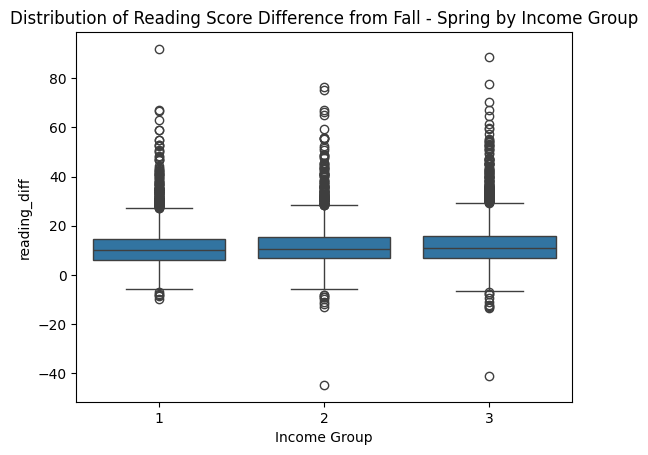

In [ ]:
ax = sns.boxplot(x = 'incomegroup', y = 'reading_diff', data = df_diff )
plt.xlabel("Income Group")
plt.title("Distribution of Reading Score Difference from Fall - Spring by Income Group")

The medians are above zero for all income groups, indicating general improvement. The distribution looks similar at a glance, with outlier patterns showing slight differences across income groups.

### Math

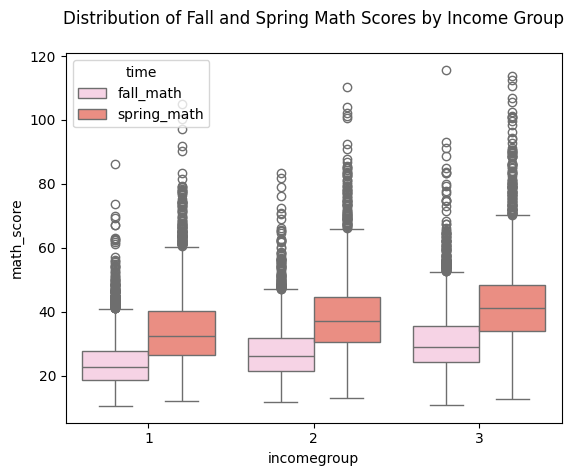

-------------------------------------------------------------------------------- 

                             sum_sq       df         F  PR(>F)
C(incomegroup)           247700.075      2.0  1196.965     0.0
C(time)                  679434.506      1.0  6566.486     0.0
C(incomegroup):C(time)     2216.788      2.0    10.712     0.0
Residual                2468794.901  23860.0       NaN     NaN
-------------------------------------------------------------------------------- 



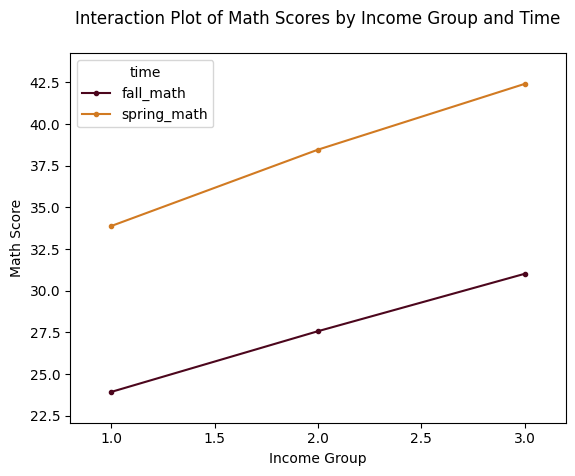

-------------------------------------------------------------------------------- 

Tukeys HSD for Income Groups

   group1  group2   Diff  Lower  Upper  q-value  p-value
0       3       2  3.696  3.298  4.093   30.819    0.001
1       3       1  7.809  7.432  8.185   68.730    0.001
2       2       1  4.113  3.744  4.482   36.916    0.001
-------------------------------------------------------------------------------- 


Tukeys HSD for Time

      group1       group2    Diff   Lower   Upper  q-value  p-value
0  fall_math  spring_math  10.671  10.413  10.929  114.599    0.001
-------------------------------------------------------------------------------- 

Effect Size for Income Group: 0.091
Effect Size for Time: 0.216
Effect Size for Interaction: 0.001
-------------------------------------------------------------------------------- 



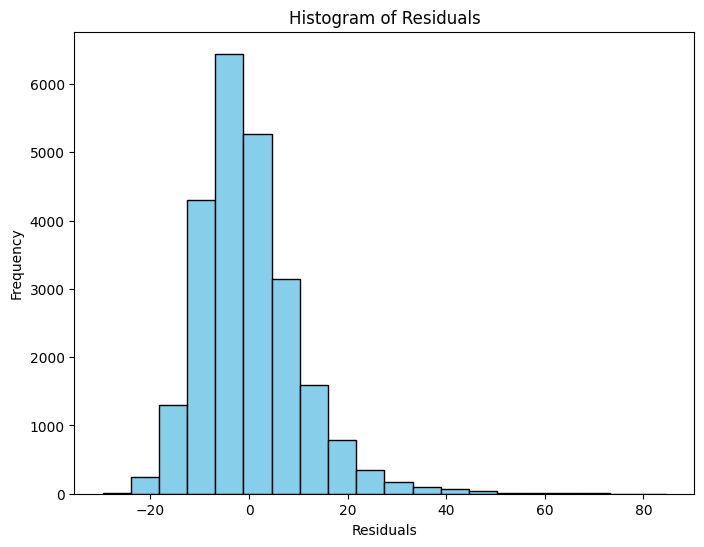

Normality of residuals (Shapiro-Wilk): Stat=0.937, p-value=0.000
-------------------------------------------------------------------------------- 

Homogeneity of variances (Levene’s test): Stat=161.638, p-value=0.000


In [ ]:
two_way_anova(df,'math')

Text(0.5, 1.0, 'Distribution of Math Score Difference from Fall - Spring by Income Group')

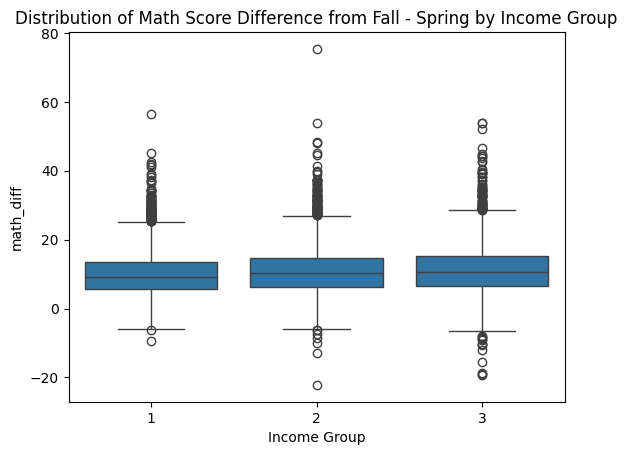

In [ ]:
ax = sns.boxplot(x = 'incomegroup', y = 'math_diff', data = df_diff )
plt.xlabel("Income Group")
plt.title("Distribution of Math Score Difference from Fall - Spring by Income Group")

### General Knowledge

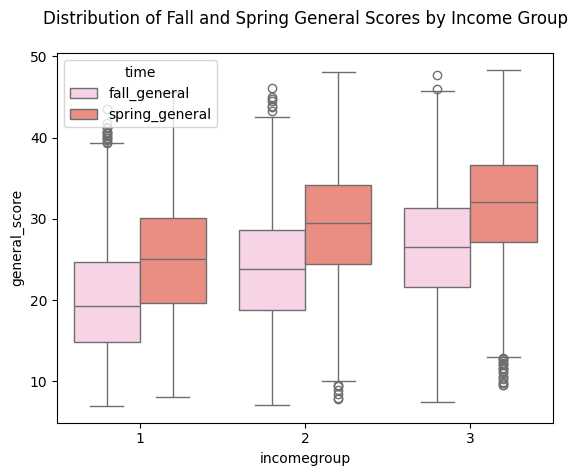

-------------------------------------------------------------------------------- 

                             sum_sq       df         F  PR(>F)
C(incomegroup)           177441.241      2.0  1824.093   0.000
C(time)                  158978.037      1.0  3268.584   0.000
C(incomegroup):C(time)       23.884      2.0     0.246   0.782
Residual                1160507.472  23860.0       NaN     NaN
-------------------------------------------------------------------------------- 



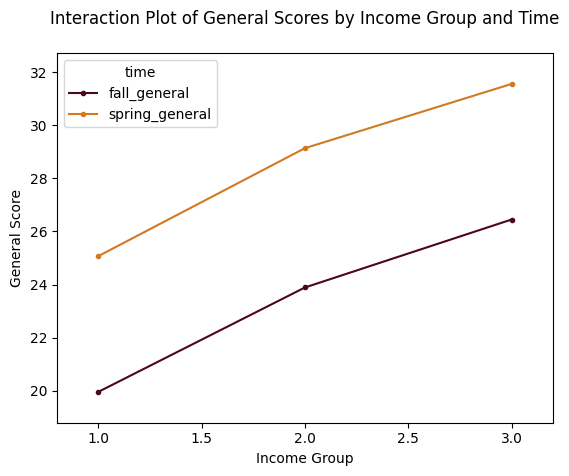

-------------------------------------------------------------------------------- 

Tukeys HSD for Income Groups

   group1  group2   Diff  Lower  Upper  q-value  p-value
0       3       2  2.494  2.222  2.767   30.335    0.001
1       3       1  6.501  6.243  6.759   83.463    0.001
2       2       1  4.007  3.754  4.260   52.460    0.001
-------------------------------------------------------------------------------- 


Tukeys HSD for Time

         group1          group2   Diff  Lower  Upper  q-value  p-value
0  fall_general  spring_general  5.162  4.985  5.339   80.853    0.001
-------------------------------------------------------------------------------- 

Effect Size for Income Group: 0.133
Effect Size for Time: 0.12
Effect Size for Interaction: 0.0
-------------------------------------------------------------------------------- 



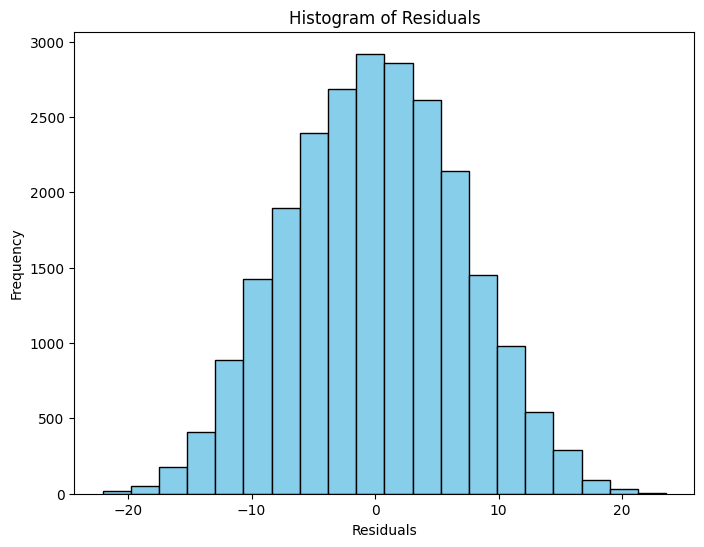

Normality of residuals (Shapiro-Wilk): Stat=0.998, p-value=0.000
-------------------------------------------------------------------------------- 

Homogeneity of variances (Levene’s test): Stat=6.627, p-value=0.000


In [ ]:
two_way_anova(df,'general')

Text(0.5, 1.0, 'Distribution of General Knowledge Score Difference from Fall - Spring by Income Group')

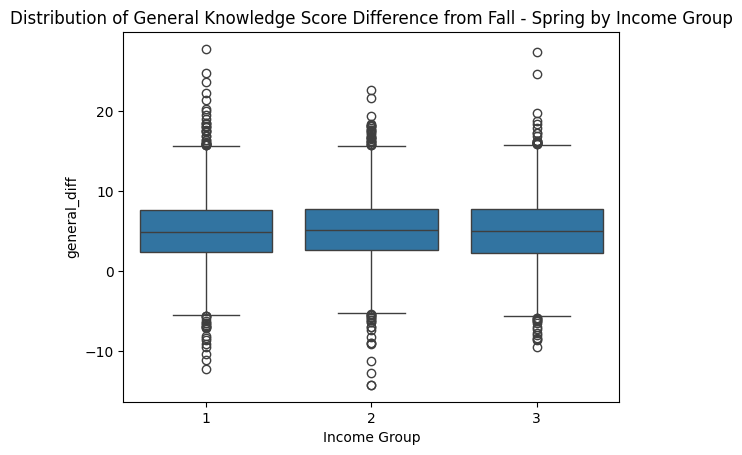

In [ ]:
ax = sns.boxplot(x = 'incomegroup', y = 'general_diff', data = df_diff )
plt.xlabel("Income Group")
plt.title("Distribution of General Knowledge Score Difference from Fall - Spring by Income Group")